In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd

In [20]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [21]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [22]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [23]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [24]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [25]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [26]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [27]:
# Design a query to retrieve the last 24 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
prev_year = str(dt.date.today() - dt.timedelta(days=730))
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(prev_year)
print(latest_date)

2017-02-06
('2017-08-23',)


C:\Users\ferna\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


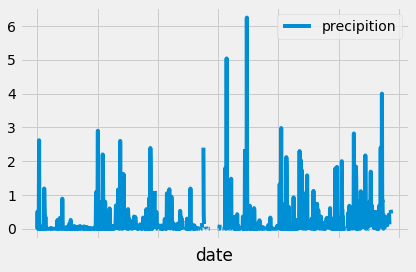

In [29]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns =['date','precipition'])
df.set_index(df['date'],inplace= True)

# Sort the dataframe by date
df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat = True)

# Rotate the xticks for the dates
plt.xticks(rotation='50')
plt.tight_layout()

In [30]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipition
count,1068.000000
mean,0.185655
std,0.479373
min,0.000000
25%,0.000000
50%,0.010000
75%,0.130000
max,6.250000


In [31]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

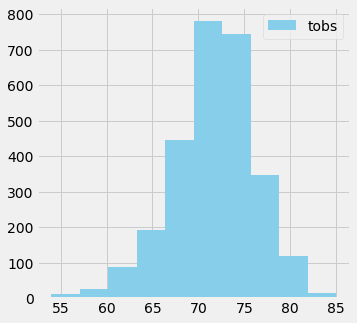

In [34]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_1 = session.query(Measurement.tobs).filter_by(station='USC00519281').all()
df_1 = [int(x[0]) for x in df_1]
plt.figure(figsize=(5,5))
plt.hist(df_1, 10, facecolor='skyblue')
plt.legend(["tobs"])
plt.show()

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-02-06', '2017-08-23'))

[(58.0, 75.0204255319149, 87.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_1 = calc_temps('2017-06-11','2017-06-25')
print(temp_1)

[(71.0, 76.90425531914893, 83.0)]


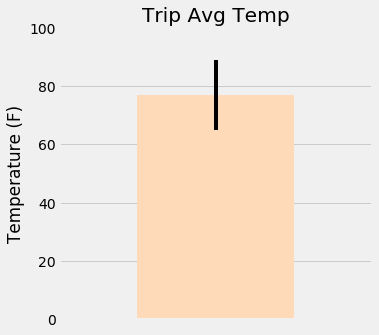

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(5,5))
plt.bar(0.5,temp_1[0][1],0.050,yerr=temp_1[0][2]-temp_1[0][0], color = "#FFDAB9")
plt.ylabel("Temperature (F)")
plt.title("Trip Avg Temp")
plt.xlim(0.45,0.55)
plt.ylim(0,100)
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.show()

In [40]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, \
              func.sum(Measurement.prcp)/func.count(Measurement.id)).group_by(Measurement.station).\
              order_by(func.sum(Measurement.prcp)/func.count(Measurement.id).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.40891653905055064),
 ('USC00519281',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.21235209235210797),
 ('USC00513117',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.14124031007752375),
 ('USC00518838',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.13868884540117277),
 ('USC00519523',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.11078306481828476),
 ('USC00514830',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.10648955495004188),
 ('USC00519397',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.048318649045518136),
 ('USC00511918',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.046831733198583345),
 ('USC00517948',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.031661807580174825)]

## Optional Challenge Assignment

In [41]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [42]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
normals = []
# Use the start and end date to create a range of dates
start_date = "12-01"
start_date = dt.datetime.strptime(start_date,'%m-%d')
end_date = "01-06"
end_date = dt.datetime.strptime(end_date,'%m-%d')
step = dt.timedelta(days=1)

# Use the start and end date to create a range of dates
date_range = []
if start_date>=end_date:
    while start_date<=dt.datetime.strptime("12-31",'%m-%d'):
        date_range.append(dt.datetime.strftime(start_date,'%m-%d'))
        start_date += step
    start_date  = start_date.replace(year=start_date.year-1)
while start_date<= end_date:
    date_range.append(dt.datetime.strftime(start_date,'%m-%d'))
    start_date += step    

# Loop through the list of %m-%d strings and calculate the normals for each date
for i in date_range:
    print(daily_normals(i))


[(65.0, 71.91666666666667, 78.0)]
[(62.0, 71.32692307692308, 77.0)]
[(67.0, 72.88679245283019, 79.0)]
[(66.0, 72.17647058823529, 81.0)]
[(64.0, 70.92156862745098, 78.0)]
[(61.0, 69.3921568627451, 78.0)]
[(58.0, 69.2, 79.0)]
[(60.0, 70.27450980392157, 83.0)]
[(64.0, 71.90196078431373, 80.0)]
[(61.0, 71.24528301886792, 78.0)]
[(64.0, 72.38775510204081, 78.0)]
[(64.0, 70.88235294117646, 79.0)]
[(65.0, 70.9423076923077, 80.0)]
[(65.0, 71.18, 78.0)]
[(62.0, 71.34, 79.0)]
[(60.0, 69.62264150943396, 82.0)]
[(63.0, 70.64, 77.0)]
[(63.0, 71.28, 77.0)]
[(67.0, 72.0, 78.0)]
[(65.0, 72.91304347826087, 81.0)]
[(67.0, 72.13953488372093, 78.0)]
[(67.0, 71.1304347826087, 77.0)]
[(61.0, 70.34693877551021, 78.0)]
[(62.0, 70.0625, 78.0)]
[(60.0, 71.75, 79.0)]
[(63.0, 71.44680851063829, 77.0)]
[(62.0, 71.91666666666667, 79.0)]
[(62.0, 70.52083333333333, 77.0)]
[(57.0, 70.29166666666667, 78.0)]
[(63.0, 69.86363636363636, 76.0)]
[(56.0, 68.27906976744185, 77.0)]
[(62.0, 69.15384615384616, 77.0)]
[(60.0, 69.

In [43]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_data = {'date':[],'tmin':[],'tavg':[],'tmax':[]}
for i in date_range:
    trip_data["date"].append(i)
    trip_data["tmin"].append(daily_normals(i)[0][0])
    trip_data["tavg"].append(daily_normals(i)[0][1])
    trip_data["tmax"].append(daily_normals(i)[0][2])
df_2 = pd.DataFrame(trip_data)
df_2 = df_2.set_index('date')
df_2

,tmin,tavg,tmax
date,,,
12-01,65.0,71.916667,78.0
12-02,62.0,71.326923,77.0
12-03,67.0,72.886792,79.0
12-04,66.0,72.176471,81.0
12-05,64.0,70.921569,78.0
12-06,61.0,69.392157,78.0
12-07,58.0,69.200000,79.0
12-08,60.0,70.274510,83.0
12-09,64.0,71.901961,80.0


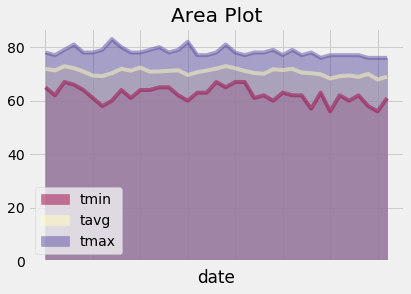

In [44]:
# Plot the daily normals as an area plot with `stacked=False`
df_2.plot(kind='area', stacked=False, alpha=0.5, colormap='Spectral',
        title='Area Plot')